<a href="https://colab.research.google.com/github/Mahnazshamissa/Python/blob/main/asigmo_dl_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup notebook environment

Make sure the Colab environment has a GPU enabled 
*Edit->Notebook settings->Hardware accelerator->Choose GPU*

In [1]:
! nvidia-smi

Thu Oct 29 17:12:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check the TensorFlow version. We need at least 2.3.0

In [2]:
! pip3 list | grep tensorflow

tensorflow                    2.3.0          
tensorflow-addons             0.8.3          
tensorflow-datasets           4.0.1          
tensorflow-estimator          2.3.0          
tensorflow-gcs-config         2.3.0          
tensorflow-hub                0.9.0          
tensorflow-metadata           0.24.0         
tensorflow-privacy            0.2.2          
tensorflow-probability        0.11.0         


# Download the dataset

In [3]:
! wget https://pub.ist.ac.at/~mlechner/datasets/f8d.tar.gz
! tar -xf f8d.tar.gz

--2020-10-29 17:12:16--  https://pub.ist.ac.at/~mlechner/datasets/f8d.tar.gz
Resolving pub.ist.ac.at (pub.ist.ac.at)... 81.223.84.195
Connecting to pub.ist.ac.at (pub.ist.ac.at)|81.223.84.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76149807 (73M) [application/x-gzip]
Saving to: ‘f8d.tar.gz’

f8d.tar.gz          100%[===================>]  72.62M  1.88MB/s    in 37s     

2020-10-29 17:12:54 (1.95 MB/s) - ‘f8d.tar.gz’ saved [76149807/76149807]



On the left-hand-side, under the "folder" symbol you can explore the directory structure

# Preparing the dataset

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

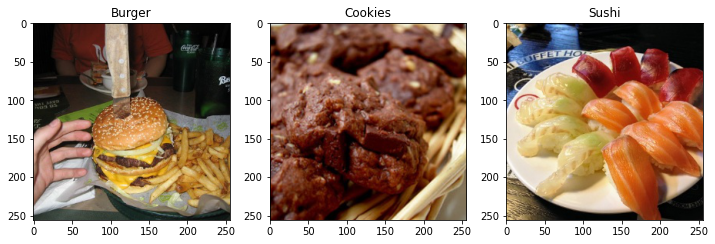

In [ ]:
example_images = [PIL.Image.open(f) for f in ["f8d/training/burger/115731679.jpg","f8d/training/cookies/1406943621.jpg","f8d/training/sushi/11774105045.jpg"]]
fig,axes = plt.subplots(1,3,figsize=(12,5))
axes[0].imshow(example_images[0])
axes[1].imshow(example_images[1])
axes[2].imshow(example_images[2])
axes[0].set_title("Burger")
axes[1].set_title("Cookies")
axes[2].set_title("Sushi")
fig.show()

In [ ]:
img = example_images[0]
print(f"Image resolution is {img.height}-by-{img.width}")

Image resolution is 256-by-256


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "f8d/test", shuffle=False, batch_size=128, image_size=(224, 224),
)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "f8d/training",
  shuffle=True,
  batch_size=64,
  image_size=(224, 224),
  validation_split=0.2,
  subset="training",
  seed=1020202,
)
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "f8d/training",
  shuffle=True,
  batch_size=128,
  image_size=(224, 224),
  validation_split=0.2,
  subset="validation",
  seed=1020202,
)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 640 files belonging to 8 classes.
Found 1840 files belonging to 8 classes.
Using 1472 files for training.
Found 1840 files belonging to 8 classes.
Using 368 files for validation.


# Our first neural network

Now we will define a simple Convolutional neural network

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(224,224,3)),
  tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
  tf.keras.layers.Conv2D(32, (5, 5), strides=2, activation="relu"),
  tf.keras.layers.Conv2D(64, (5, 5), strides=2, activation="relu"),
  tf.keras.layers.Conv2D(128, (5, 5), strides=2, activation="relu"),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(8, activation="softmax"),
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 110, 110, 32)      2432      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 53, 53, 64)        51264     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 25, 25, 128)       204928    
_________________________________________________________________
global_average_pooling2d_5 ( (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 8)                

![alt](https://github.com/mlech26l/f8d_dataset/blob/main/misc/network.png?raw=true)

The ```tf.keras.Model``` class has the following important methods:

-  ```.compile(...)``` defines training objective, metric and optimizer
-  ```.fit(...)``` trains the model
-  ```.evaluate(...)``` evaluates the model, i.e., computes the loss and metrics on a dataset
-  ```.predict(...)``` predicts the output of the network for a given inputs (batched!)

In [ ]:
training_log = model.fit(
  train_dataset, epochs=150, validation_data=valid_dataset
)

Epoch 1/150
23/23 [==============================] - 3s 134ms/step - loss: 2.0763 - sparse_categorical_accuracy: 0.1304 - val_loss: 2.0632 - val_sparse_categorical_accuracy: 0.1467
Epoch 2/150
23/23 [==============================] - 3s 118ms/step - loss: 2.0379 - sparse_categorical_accuracy: 0.1834 - val_loss: 2.0087 - val_sparse_categorical_accuracy: 0.1766
Epoch 3/150
23/23 [==============================] - 3s 119ms/step - loss: 2.0106 - sparse_categorical_accuracy: 0.1950 - val_loss: 1.9723 - val_sparse_categorical_accuracy: 0.1875
Epoch 4/150
23/23 [==============================] - 3s 117ms/step - loss: 1.9777 - sparse_categorical_accuracy: 0.2194 - val_loss: 1.9883 - val_sparse_categorical_accuracy: 0.2201
Epoch 5/150
23/23 [==============================] - 3s 119ms/step - loss: 1.9653 - sparse_categorical_accuracy: 0.2208 - val_loss: 1.8954 - val_sparse_categorical_accuracy: 0.2717
Epoch 6/150
23/23 [==============================] - 3s 118ms/step - loss: 1.9122 - sparse_cate

The ```history``` object stores the training history

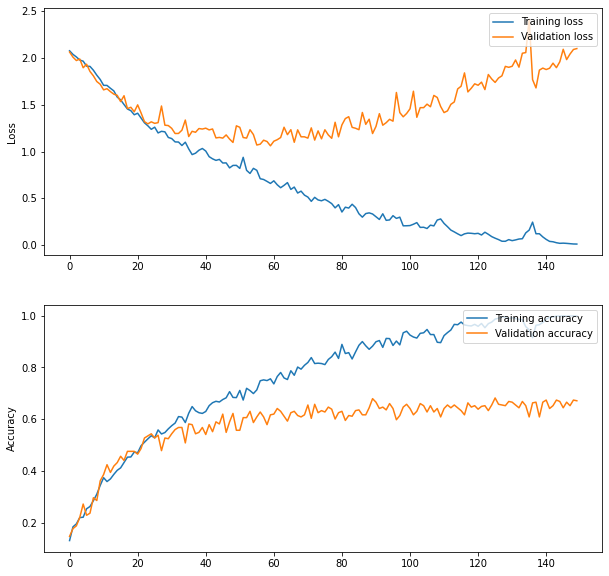

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(10,10))
axes[0].plot(training_log.history["loss"],label="Training loss")
axes[0].plot(training_log.history["val_loss"],label="Validation loss")
axes[0].legend(loc="upper right")
axes[0].set_ylabel("Loss")
axes[1].plot(training_log.history["sparse_categorical_accuracy"],label="Training accuracy")
axes[1].plot(training_log.history["val_sparse_categorical_accuracy"],label="Validation accuracy")
axes[1].legend(loc="upper right")
axes[1].set_ylabel("Accuracy")
fig.show()

# Evaluating the trained network


In [ ]:
model.evaluate(test_dataset)

5/5 [==============================] - 1s 169ms/step - loss: 2.4098 - sparse_categorical_accuracy: 0.6531


[2.409796953201294, 0.653124988079071]

# Predicting individual samples

Let's run our network through the 3 images displayed before

In [ ]:
# Resize and put the 3 images into one batch
image_batch = np.stack([np.array(img.resize((224,224))) for img in example_images])
image_batch.shape

(3, 224, 224, 3)

In [ ]:
prediction = model.predict(image_batch)

print("prediction shape",str(prediction.shape))

prediction shape (3, 8)


In [ ]:
print("First  image scores: ",str(prediction[0]))
print("Second image scores: ",str(prediction[1]))
print("Third  image scores: ",str(prediction[2]))

First  image scores:  [9.9998522e-01 8.1353340e-07 1.3318939e-05 2.9485903e-09 3.7122100e-14
 8.3253994e-11 2.7744017e-07 2.9297738e-07]
Second image scores:  [6.70074413e-11 9.99777496e-01 6.34867718e-07 2.76477613e-06
 2.05182139e-11 1.06298343e-04 1.37589122e-08 1.12711015e-04]
Third  image scores:  [2.20134680e-07 1.01143755e-11 4.65042703e-03 2.50894431e-07
 9.05823345e-06 3.07043083e-05 9.95306551e-01 2.70660462e-06]


How to interpret these numbers

In [ ]:
import os
class_names = sorted(os.listdir("f8d/training"))
class_names

['burger', 'cookies', 'hot_dog', 'pizza', 'soup', 'spaghetti', 'sushi', 'taco']

Highest scores:  [0 1 6]


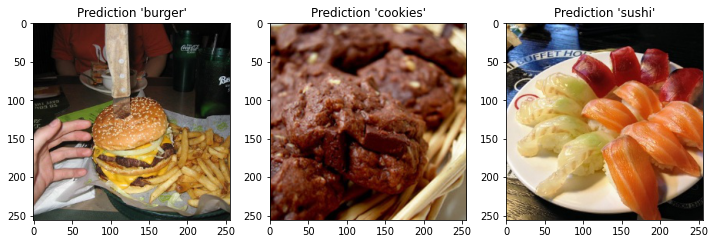

In [ ]:
highest_scores = np.argmax(prediction,axis=-1)
print("Highest scores: ",str(highest_scores))

fig,axes = plt.subplots(1,3,figsize=(12,5))
axes[0].imshow(example_images[0])
axes[1].imshow(example_images[1])
axes[2].imshow(example_images[2])
axes[0].set_title(f"Prediction '{class_names[highest_scores[0]]}'")
axes[1].set_title(f"Prediction '{class_names[highest_scores[1]]}'")
axes[2].set_title(f"Prediction '{class_names[highest_scores[2]]}'")
fig.show()

# Exercise 1